# Transactional Clustering - K-MODES

In [56]:
%matplotlib inline

import os,sys,inspect
PATH = '/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2'
sys.path.insert(0, PATH)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fma_metadata import utils
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [57]:
tracks = utils.load("/Users/gaetanoantonicchio/Desktop/dataset_DM2/fma_metadata/tracks.csv")
echo = utils.load("/Users/gaetanoantonicchio/Desktop/dataset_DM2/fma_metadata/echonest.csv")

### Pre-processing

In [58]:
tracks_feat = tracks['track'][['language_code', 'license', 'listens', 'genre_top']]

In [59]:
echo = echo['echonest']['audio_features']

In [60]:
def assign_label_valence(i):
    if i >= 0 and i <= 0.4:
        return 'sad'
    if i > 0.4:
        return 'happy'
    
def assign_label_live(i):
    if i >= 0 and i <= 0.5:
        return 'recorded_in_studio'
    if i > 0.5:
        return 'live_concert'
    
def assign_label_dance(i):
    if i >= 0 and i <= 0.5:
        return 'not_danceable'
    if i > 0.5:
        return 'danceable'

def assign_label_speech(i):
    if i >= 0 and i <= 0.2:
        return 'instrumental'
    if i>0.2 and i <= 0.7:
        return 'balaced'
    if i > 0.7:
        return 'spoken'
    
def assign_label_energy(i):
    if i >= 0 and i <= 0.3:
        return 'low'
    if i > 0.3 and i <=0.6:
        return 'medium'
    if i > 0.6:
        return 'high'

In [61]:
echo['valence'] = echo['valence'].apply(assign_label_valence)
echo['danceability'] = echo['danceability'].apply(assign_label_dance)
echo['speechiness'] = echo['speechiness'].apply(assign_label_speech)
echo['liveness'] = echo['liveness'].apply(assign_label_live)
echo['energy'] = echo['energy'].apply(assign_label_energy)

In [62]:
echo = echo[['danceability', 'energy', 'liveness', 'speechiness', 'valence']]

In [63]:
tracks_feat['listens'].describe()

count    106574.000000
mean       2329.353548
std        8028.070647
min           0.000000
25%         292.000000
50%         764.000000
75%        2018.000000
max      543252.000000
Name: listens, dtype: float64

In [64]:
def assign_label_listens(i):
    if i >= 0 and i <= 764:
        return 'low_listens'
    if i > 764 and i <=2019:
        return 'medium_listens'
    if i > 2019:
        return 'high_listens'

In [65]:
tracks_feat['listens'] = tracks_feat['listens'].apply(assign_label_listens)

In [66]:
tracks_feat.dropna(axis=0, inplace=True)

In [67]:
df = tracks_feat.merge(echo, on='track_id')

In [68]:
df.dropna(axis=0, inplace=True)

In [69]:
print(df.shape)
df.head()

(4784, 9)


,language_code,license,listens,genre_top,danceability,energy,liveness,speechiness,valence
track_id,,,,,,,,,
2,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,medium_listens,Hip-Hop,danceable,high,recorded_in_studio,instrumental,happy
3,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,low_listens,Hip-Hop,danceable,high,recorded_in_studio,balaced,sad
5,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,medium_listens,Hip-Hop,danceable,high,recorded_in_studio,instrumental,happy
10,en,Attribution-NonCommercial-NoDerivatives (aka M...,high_listens,Pop,danceable,high,recorded_in_studio,instrumental,happy
134,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,medium_listens,Hip-Hop,danceable,medium,recorded_in_studio,balaced,happy


In [70]:
from kmodes.kmodes import KModes

In [71]:
km = KModes(n_clusters=3, init='Huang', n_init=50, verbose=1)

clusters = km.fit_predict(df)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1114, cost: 11363.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1745, cost: 11627.0
Run 2, iteration: 2/100, moves: 23, cost: 11627.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 743, cost: 12757.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1070, cost: 11451.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 1262, cost: 11562.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 1062, cost: 11841.0
Run 6, iteration: 2/100, moves: 207, cost: 11841.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, mov

In [73]:
km.cluster_centroids_

array([['en', 'Attribution-Noncommercial-Share Alike 3.0 United States',
        'low_listens', 'Rock', 'danceable', 'medium',
        'recorded_in_studio', 'instrumental', 'happy'],
       ['en', 'Attribution-Noncommercial-Share Alike 3.0 United States',
        'low_listens', 'Folk', 'not_danceable', 'low',
        'recorded_in_studio', 'instrumental', 'sad'],
       ['en', 'Attribution-Noncommercial-Share Alike 3.0 United States',
        'low_listens', 'Rock', 'not_danceable', 'high',
        'recorded_in_studio', 'instrumental', 'sad']], dtype='<U55')

In [74]:
km.labels_

array([0, 2, 0, ..., 2, 0, 1], dtype=uint16)

In [75]:
df['clusters'] = km.labels_

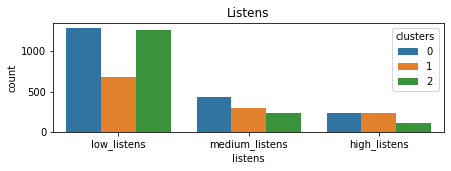

In [77]:
import seaborn as sns

plt.subplots(figsize = (7,2))
sns.countplot(x=df['listens'],order=df['listens'].value_counts().index,hue=df['clusters'])
plt.title('Listens')
plt.show()

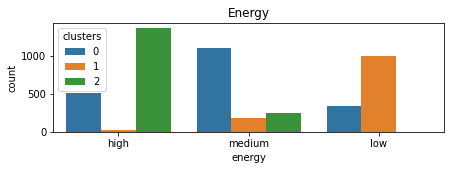

In [78]:
plt.subplots(figsize = (7,2))
sns.countplot(x=df['energy'],order=df['energy'].value_counts().index,hue=df['clusters'])
plt.title('Energy')
plt.show()

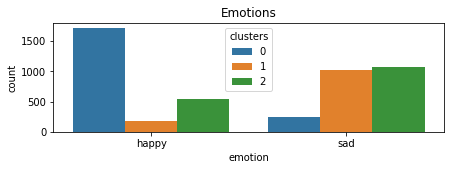

In [79]:
plt.subplots(figsize = (7,2))
sns.countplot(x=df['valence'],order=df['valence'].value_counts().index,hue=df['clusters'])
plt.title('Emotions')
plt.xlabel('emotion')
plt.show()

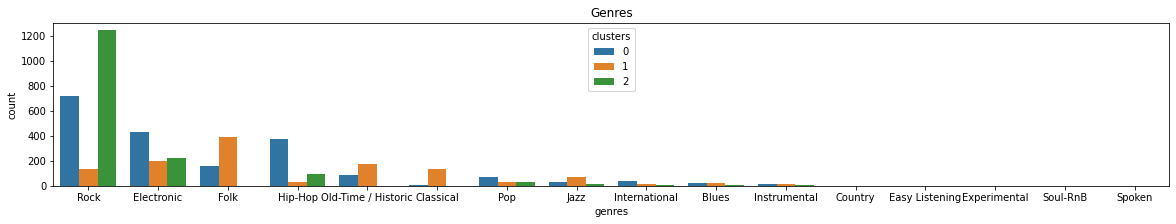

In [80]:
plt.subplots(figsize = (20,3))
sns.countplot(x=df['genre_top'],order=df['genre_top'].value_counts().index,hue=df['clusters'])
plt.title('Genres')
plt.xlabel('genres')
plt.show()

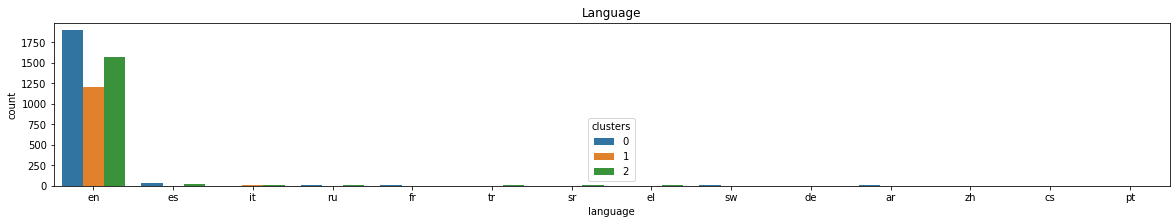

In [81]:
plt.subplots(figsize = (20,3))
sns.countplot(x=df['language_code'],order=df['language_code'].value_counts().index,hue=df['clusters'])
plt.title('Language')
plt.xlabel('language')
plt.show()

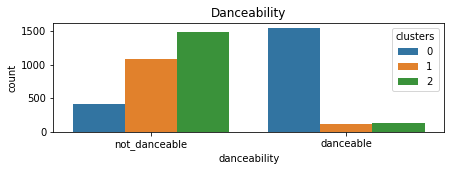

In [82]:
plt.subplots(figsize = (7,2))
sns.countplot(x=df['danceability'],order=df['danceability'].value_counts().index,hue=df['clusters'])
plt.title('Danceability')
plt.show()

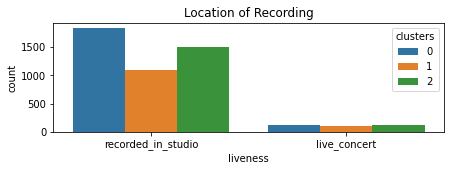

In [83]:
plt.subplots(figsize = (7,2))
sns.countplot(x=df['liveness'],order=df['liveness'].value_counts().index,hue=df['clusters'])
plt.title('Location of Recording')
plt.show()

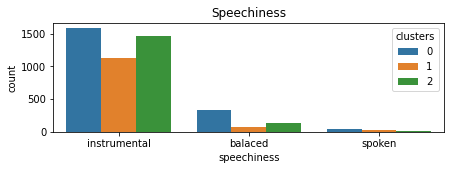

In [84]:
plt.subplots(figsize = (7,2))
sns.countplot(x=df['speechiness'],order=df['speechiness'].value_counts().index,hue=df['clusters'])
plt.title('Speechiness')
plt.show()